In [1]:
import pandas as pd
import seaborn as sns
import glob
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib.pyplot import legend
from scipy.stats import ks_2samp, chi2_contingency, fisher_exact, linregress, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
import numpy as np
import gc
from natsort import index_natsorted
np.random.seed(12)

In [2]:
def split_cpg_counts(df):
    cpg_count = df[df['kmer'].isin(['CG'])]['count'].sum()
    non_cpg_count = df[~df['kmer'].isin(['CG'])]['count'].sum()
    return cpg_count, non_cpg_count
def split_tpg_counts(df):
    tpg_count = df[df['kmer'].isin(['TG',])]['count'].sum()
    non_tpg_count = df[~df['kmer'].isin(['TG'])]['count'].sum()
    return tpg_count, non_tpg_count
def make_cpg_density_df(seqdict, assembly, region):
    cpg_density_dict = {'chromosome':[],
               'CpG_count':[],
               'C_count':[],
               'G_count':[],
               'Exp_CpG_count':[],
               'Rel_Freq_CpG':[]}
    
    for k, v in tqdm(seqdict.items()):
        # if k not in chroms:
        #     continue
        # if k in ['20', 'Y']:
        #     continue
        cg = v.seq.upper().count('CG')
        c = v.seq.upper().count('C')
        g = v.seq.upper().count('G')
        # exp_cg = c * g
        exp_cg = (c * g) / len(v.seq)

        num_dinucleotides = len(v.seq) - 1
        # p_cg = cg / num_dinucleotides
        # p_c = c / len(v.seq)
        # p_g = g / len(v.seq)

        # if 'X' in k:
        #     cpg_density_dict['Chrom_type'].append('X')
        # else:
        #     cpg_density_dict['Chrom_type'].append('Autosome')

        cpg_density_dict['chromosome'].append(k.split(":")[0])
        cpg_density_dict['CpG_count'].append(cg)
        cpg_density_dict['C_count'].append(c)
        cpg_density_dict['G_count'].append(g)
        cpg_density_dict['Exp_CpG_count'].append(exp_cg)
        cpg_density_dict['Rel_Freq_CpG'].append((cg / num_dinucleotides)*100)
    df = pd.DataFrame.from_dict(cpg_density_dict)
    df = df.groupby('chromosome', as_index=False).sum()
    df['Assembly'] = assembly
    df['Region'] = region
    return df

In [3]:
# Load the centromere and non-centromere kmer counts
centromere_kmers = pd.read_csv('../../bovine_pangenome/TuWa_manuscript/kmers/tsvs/UOA_Wagyu.centromeres.2mer.tsv.gz',
                               sep='\t',
                               names=['kmer','count'])
non_centromere_kmers = pd.read_csv('../../bovine_pangenome/TuWa_manuscript/kmers/tsvs/UOA_Wagyu.non-centromeres.2mer.tsv.gz',
                                   sep='\t',
                                   names=['kmer','count'])
centromere_kmers.head()

,kmer,count
0,AA,14977590
1,AC,15324470
2,AG,11462035
3,AT,11570157
4,CA,15242595


In [4]:
centro_cpg, centro_non_cpg = split_cpg_counts(centromere_kmers)
non_centro_cpg, non_centro_non_cpg = split_cpg_counts(non_centromere_kmers)
print(f'Centromere CPG: {centro_cpg}')
print(f'Centromere non-CPG: {centro_non_cpg}')
print(f'Non-centromere CPG: {non_centro_cpg}')
print(f'Non-centromere non-CPG: {non_centro_non_cpg}')

Centromere CPG: 11952968
Centromere non-CPG: 159111427
Non-centromere CPG: 28231884
Non-centromere non-CPG: 1426117385


In [5]:
obs = pd.DataFrame.from_dict(
    {'is_CpG':[centro_cpg, non_centro_cpg],
     'not_CpG':[centro_non_cpg, non_centro_non_cpg]},
     columns=['Centromere', 'Non-Centromere'],
     orient='index')
obs

,Centromere,Non-Centromere
is_CpG,11952968,28231884
not_CpG,159111427,1426117385


In [6]:
# Genome-wide centromere vs non-centromere CpG enrichment
obs = pd.DataFrame.from_dict(
    {'is_CpG':[centro_cpg, non_centro_cpg],
     'not_CpG':[centro_non_cpg, non_centro_non_cpg]},
     columns=['Centromere', 'Non-Centromere'],
     orient='index').to_numpy()
print('Genome-wide Centromeres vs Non-centromeres')
print(centro_cpg / centro_non_cpg)
print(non_centro_cpg / non_centro_non_cpg)
print(fisher_exact(obs))

Genome-wide Centromeres vs Non-centromeres
0.0751232530897985
0.01979632553178643
SignificanceResult(statistic=3.7948079288338183, pvalue=0.0)


In [7]:
# CpG density
# Calculate the CpG density of each centromere
centromere_fasta = SeqIO.to_dict(SeqIO.parse('../../bovine_pangenome/TuWa_manuscript/kmers/fa/UOA_Wagyu.centromeres.fa', 'fasta'))

whole_centromere_cpg_density = {'chromosome':[],
                                'CpG_count':[],
                                'C_count':[],
                                'G_count':[],
                                'Exp_CpG_count':[],
                                'Rel_Freq_CpG':[]}


for k, v in centromere_fasta.items():
    cg = v.seq.upper().count('CG')
    c = v.seq.upper().count('C')
    g = v.seq.upper().count('G')
    # exp_cg = c * g
    exp_cg = (c * g) / len(v.seq)

    num_dinucleotides = len(v.seq) - 1
    # p_cg = cg / num_dinucleotides
    # p_c = c / len(v.seq)
    # p_g = g / len(v.seq)

    whole_centromere_cpg_density['chromosome'].append(k.split(":")[0])
    whole_centromere_cpg_density['CpG_count'].append(cg)
    whole_centromere_cpg_density['C_count'].append(c)
    whole_centromere_cpg_density['G_count'].append(g)
    whole_centromere_cpg_density['Exp_CpG_count'].append(exp_cg)
    whole_centromere_cpg_density['Rel_Freq_CpG'].append((cg / num_dinucleotides)*100)
    # whole_centromere_cpg_density['CpG_proportion'].append(p_cg)
    # whole_centromere_cpg_density['C_proportion'].append(p_c)
    # whole_centromere_cpg_density['G_proportion'].append(p_g)
    # whole_centromere_cpg_density['CpG_density'].append((p_cg / (p_c * p_g)))
    # whole_centromere_cpg_density['Num_nucleotides'].append(len(v.seq))
    # whole_centromere_cpg_density['num_dinucleotides'].append(num_dinucleotides)
# whole_centromere_cpg_density['chromosome'].append('20')
# whole_centromere_cpg_density['CpG_count'].append(np.nan)
# whole_centromere_cpg_density['C_count'].append(np.nan)
# whole_centromere_cpg_density['G_count'].append(np.nan)
# whole_centromere_cpg_density['Exp_CpG_count'].append(np.nan)
# whole_centromere_cpg_density['Rel_Freq_CpG'].append(np.nan)

cpg_den = pd.DataFrame.from_dict(whole_centromere_cpg_density)

cpg_den['Obs_Exp_CpG'] = cpg_den['CpG_count'] / cpg_den['Exp_CpG_count']
cpg_den

,chromosome,CpG_count,C_count,G_count,Exp_CpG_count,Rel_Freq_CpG,Obs_Exp_CpG
0,1,1088967,6474115,5197481,1.602338e+06,5.185557,0.679611
1,2,520371,2570611,2361162,6.744032e+05,5.781901,0.771602
2,3,882258,5434390,4686887,1.340546e+06,4.643463,0.658133
3,4,945060,5294638,3952574,1.307966e+06,5.906625,0.722542
4,5,513999,3218360,2682838,7.849399e+05,4.672719,0.654826
5,6,627147,4135067,3636129,1.002376e+06,4.180980,0.625661
6,7,662944,4117252,3661183,1.004934e+06,4.419627,0.659689
7,8,588477,3631506,3325565,9.289853e+05,4.526747,0.633462
8,9,1191736,6976019,5876906,1.782496e+06,5.181461,0.668577
9,10,682575,4136181,3560943,1.052050e+06,4.875536,0.648805


In [8]:
fa_files = [('../../bovine_pangenome/TuWa_manuscript/kmers/fa/UOA_Wagyu.centromeres.fa', 'UOA_Wagyu_1', 'Centromere'),
            ('../../bovine_pangenome/TuWa_manuscript/kmers/fa/UOA_Wagyu.non-centromeres.fa', 'UOA_Wagyu_1', 'Non-Centromere'),
            ('../../REFERENCES/Human/hs1/hs1.centromere.fa', 'hs1', 'Centromere'),
            ('../../REFERENCES/Human/hs1/hs1.non-centromere.fa', 'hs1', 'Non-Centromere')]

cpg_density_df = pd.DataFrame()
for fa, assembly, region in fa_files:
    fasta = SeqIO.to_dict(SeqIO.parse(fa, 'fasta'))
    cpg_density_df = pd.concat([cpg_density_df, make_cpg_density_df(fasta, assembly, region)])
cpg_density_df

100%|██████████| 41/41 [00:16<00:00,  2.43it/s]


,chromosome,CpG_count,C_count,G_count,Exp_CpG_count,Rel_Freq_CpG,Assembly,Region
0,1,1088967,6474115,5197481,1.602338e+06,5.185557,UOA_Wagyu_1,Centromere
1,10,682575,4136181,3560943,1.052050e+06,4.875536,UOA_Wagyu_1,Centromere
2,11,298576,1968664,1680955,4.727479e+05,4.265372,UOA_Wagyu_1,Centromere
3,12,876021,5556022,5011119,1.392094e+06,4.380105,UOA_Wagyu_1,Centromere
4,13,382080,2353786,1959907,5.766502e+05,4.776001,UOA_Wagyu_1,Centromere
...,...,...,...,...,...,...,...,...
18,chr6,1431235,31682271,31711052,6.315704e+06,1.889842,hs1,Non-Centromere
19,chr7,1473749,29984391,29922050,6.092388e+06,2.011501,hs1,Non-Centromere
20,chr8,1246990,26995019,26958569,5.426665e+06,1.968546,hs1,Non-Centromere
21,chr9,1123321,22602677,22585843,4.699181e+06,1.971298,hs1,Non-Centromere


Wagyu centromere r2: 0.9517333182182813 5.695862394802876e-20
Human centromere r2: 0.8355686204473777 1.09361398834596e-09


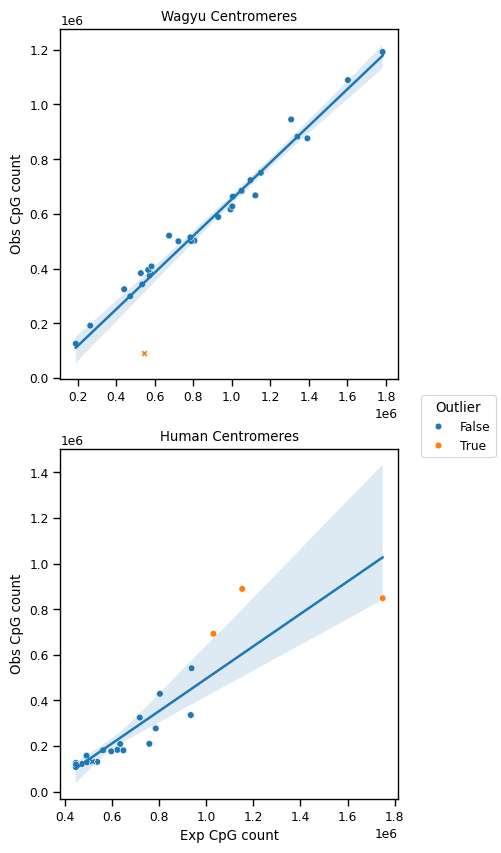

In [9]:
sns.set_context('paper')
# Side by side plots
fig, ax = plt.subplots(2, 1, figsize=(5, 10))



# Assuming x is already defined as a DataFrame
x = cpg_density_df.copy()
x = x.dropna(axis='index')

wagyu_cent = x[(x['Assembly'] == 'UOA_Wagyu_1') & (x['Region'] == 'Centromere')]
hs1_cent = x[(x['Assembly'] == 'hs1') & (x['Region'] == 'Centromere')]


wagyu_cent = wagyu_cent.copy()
hs1_cent = hs1_cent.copy()



# Perform linear regression
# slope, intercept, r_value, p_value, std_err = linregress(wagyu['Exp_CpG_count'], wagyu['CpG_count'])
wagyu_c_linreg = linregress(wagyu_cent['Exp_CpG_count'], wagyu_cent['CpG_count'])
hs1_c_linreg = linregress(hs1_cent['Exp_CpG_count'], hs1_cent['CpG_count'])


# Calculate predicted values
# x['Predicted_Obs_CpG'] = intercept + slope * x['Exp_CpG_count']
wagyu_cent['Predicted_Obs_CpG'] = wagyu_c_linreg.intercept + wagyu_c_linreg.slope * wagyu_cent['Exp_CpG_count']
hs1_cent['Predicted_Obs_CpG'] = hs1_c_linreg.intercept + hs1_c_linreg.slope * hs1_cent['Exp_CpG_count']


# Calculate residuals
# x['Residuals'] = x['CpG_count'] - x['Predicted_Obs_CpG']
wagyu_cent['Residuals'] = wagyu_cent['CpG_count'] - wagyu_cent['Predicted_Obs_CpG']
hs1_cent['Residuals'] = hs1_cent['CpG_count'] - hs1_cent['Predicted_Obs_CpG']


# Calculate standard error of the residuals
# se_residuals = np.std(x['Residuals'])
wagyu_c_se_residuals = np.std(wagyu_cent['Residuals']) / np.sqrt(len(wagyu_cent))
hs1_c_se_residuals = np.std(hs1_cent['Residuals']) / np.sqrt(len(hs1_cent))



# Define confidence interval (e.g., 95% confidence interval)
# confidence_interval = 1.96 * se_residuals
wagyu_c_confidence_interval = 1.96 * wagyu_c_se_residuals
hs1_c_confidence_interval = 1.96 * hs1_c_se_residuals


# Identify outliers
# x['Outlier'] = np.abs(x['Residuals']) > confidence_interval

# Identify outliers based on IQR of residuals
wagyu_cent['q25'] = wagyu_cent['Residuals'].quantile(0.25)
wagyu_cent['q75'] = wagyu_cent['Residuals'].quantile(0.75)
wagyu_cent['IQR'] = wagyu_cent['q75'] - wagyu_cent['q25']
wagyu_cent['Outlier'] = (wagyu_cent['Residuals'] < (wagyu_cent['q25'] - 1.5 * wagyu_cent['IQR'])) | (wagyu_cent['Residuals'] > (wagyu_cent['q75'] + 1.5 * wagyu_cent['IQR']))

hs1_cent['q25'] = hs1_cent['Residuals'].quantile(0.25)
hs1_cent['q75'] = hs1_cent['Residuals'].quantile(0.75)
hs1_cent['IQR'] = hs1_cent['q75'] - hs1_cent['q25']
hs1_cent['Outlier'] = (hs1_cent['Residuals'] < (hs1_cent['q25'] - 1.5 * hs1_cent['IQR'])) | (hs1_cent['Residuals'] > (hs1_cent['q75'] + 1.5 * hs1_cent['IQR']))


wagyu_cent['Is_X'] = wagyu_cent['chromosome'] == 'X'
hs1_cent['Is_X'] = hs1_cent['chromosome'] == 'chrX'



# wagyu_cent['Outlier'] = np.abs(wagyu_cent['Residuals']) > wagyu_c_confidence_interval
# hs1_cent['Outlier'] = np.abs(hs1_cent['Residuals']) > hs1_c_confidence_interval
# wagyu_non_cent['Outlier'] = np.abs(wagyu_non_cent['Residuals']) > wagyu_nc_confidence_interval
# hs1_non_cent['Outlier'] = np.abs(hs1_non_cent['Residuals']) > hs1_nc_confidence_interval

# Plot the regression plot with outliers highlighted

markers={True: 's', False: 's'}
pal = {True: '#FF7F0E', False: '#1F77B4'}

sns.regplot(data=wagyu_cent, x='Exp_CpG_count', y='CpG_count', ci=95,
             ax=ax[0], scatter=False)
sns.scatterplot(data=wagyu_cent[wagyu_cent['chromosome'] != 'X'], x='Exp_CpG_count', y='CpG_count',
                ax=ax[0], hue='Outlier',marker='o')
sns.scatterplot(data=wagyu_cent[wagyu_cent['Is_X']], x='Exp_CpG_count', y='CpG_count',
                ax=ax[0], marker='X', hue='Outlier', palette=pal)

sns.regplot(data=hs1_cent, x='Exp_CpG_count', y='CpG_count', ci=95, ax=ax[1],
            scatter=False)
sns.scatterplot(data=hs1_cent[~hs1_cent['Is_X']], x='Exp_CpG_count', y='CpG_count',
                 ax=ax[1], hue='Outlier', marker='o')
sns.scatterplot(data=hs1_cent[hs1_cent['Is_X']], x='Exp_CpG_count', y='CpG_count',
                ax=ax[1], marker='X', hue='Outlier', palette=pal)




# Print outliers
wagyu_c_outliers = wagyu_cent[wagyu_cent['Outlier']]
hs1_c_outliers = hs1_cent[hs1_cent['Outlier']]

# print(wagyu_c_outliers)
# print(wagyu_nc_outliers)
# print('###############')
# print(hs1_c_outliers)
# print(hs1_nc_outliers)
ax[0].set_title('Wagyu Centromeres')
ax[1].set_title('Human Centromeres')


ax[0].set_xlabel('')
ax[0].set_ylabel('Obs CpG count')
ax[1].set_xlabel('Exp CpG count')
ax[1].set_ylabel('Obs CpG count')


ax[0].legend().remove()
ax[1].legend().remove()


# Move legend outside of plot
handles, labels = ax[1].get_legend_handles_labels()


wagyu_cent_r2 = wagyu_c_linreg.rvalue**2
human_cent_r2 = hs1_c_linreg.rvalue**2


print(f'Wagyu centromere r2: {wagyu_cent_r2}', wagyu_c_linreg.pvalue)
print(f'Human centromere r2: {human_cent_r2}', hs1_c_linreg.pvalue)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
fig.legend(handles[:-1], labels[:-1], loc='center right', title='Outlier')

# Move the legend so it doesn't overlap with the plots
plt.subplots_adjust(right=0.8)


# plt.savefig('/Users/callummacphillamy/Library/CloudStorage/OneDrive-UniversityofAdelaide/Postdoc/Bovine_pangenome/genome_assembly_and_svs/MANUSCRIPT/images/CpG_density_regression.hs1VsWagyu.png', dpi=400)